In [ ]:
#imports
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display
import datetime
import threading
import logging
import time
import itertools
import smtplib
from email.mime.text import MIMEText
from collections import Counter
import csv
import spotipy
from spotipy.oauth2 import SpotifyOAuth
import os
import spotify_utils as spu
from operator import itemgetter
from os.path import join as pj

from sklearn.linear_model import LinearRegression,LogisticRegression

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,f1_score

from imblearn.over_sampling import RandomOverSampler,SMOTE
from imblearn.under_sampling import RandomUnderSampler,TomekLinks
from imblearn.pipeline import Pipeline


from math import sqrt

In [ ]:
# constants
REFRESH_CACHE = False
seen_playlist_id = "5al4jEBoq01LPmFDuGDnq4"      # Automated: Reviewed Items
played_playlist_id = "7EHT9D4ygqDlyGfqcFvkUv"    # 5 Esh Played
inbox_playlist_id = "1xsuqA0HU4bSosdaPyVlWG"     # 1 Esh Review
features_to_use = ["duration","previous_artist_plays"] + spu.audio_features_to_use


In [ ]:
if REFRESH_CACHE:
    sp = spu.spotify_connect()
    seen_tracks = spu.get_playlist_tracks(sp,seen_playlist_id,audio_features=True)
    played_tracks = spu.get_playlist_tracks(sp,played_playlist_id)
    review_tracks = spu.get_playlist_tracks(sp,inbox_playlist_id,audio_features=True)
    seen_tracks.to_csv('seen_tracks.csv',index=False)
    played_tracks.to_csv('played_tracks.csv',index=False)
    review_tracks.to_csv('review_tracks.csv',index=False)

In [ ]:
seen_tracks = pd.read_csv('seen_tracks.csv')
played_tracks = pd.read_csv('played_tracks.csv')["id"]
seen_tracks = seen_tracks.merge(played_tracks,how='left',on=["id"],indicator="played")
seen_tracks["played"] = seen_tracks["played"].apply(lambda i: 1 if i=="both" else 0)
seen_tracks = seen_tracks.dropna()

In [ ]:
import duckdb
import pandas as pd
import sqlalchemy
# No need to import duckdb_engine
#  SQLAlchemy will auto-detect the driver needed based on your connection string!

# Import ipython-sql Jupyter extension to create SQL cells
%load_ext sql
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False
%sql duckdb:///:memory:
%sql SELECT 'Off and flying!' as a_duckdb_column

In [ ]:
%sql t0 << select * from seen_tracks
%sql select count(*) from t0

In [ ]:
%%sql t1 << 
select * 
from (
    select *,row_number() over (partition by artist_id,track_name order by playlist_offset) as duplicate_index
    from t0
)
where duplicate_index = 1

In [ ]:
t1["played"].value_counts()

In [ ]:
%%sql t2 <<
select * from (
    select *,
    sum(played) over (partition by artist_id) as total_artist_plays
    from t1
)
where total_artist_plays < 2 or played

In [ ]:
t2["played"].value_counts()

In [ ]:
%%sql t3 <<
select *,coalesce(sum(played) over (
    partition by artist_id
    order by playlist_offset
    rows between unbounded preceding and 1 preceding 
    ),0) as previous_artist_plays
from t2

In [ ]:
t3["previous_artist_plays"].value_counts()

In [ ]:
X = t3[features_to_use]
y = t3["played"]

In [38]:



def discrete_scatter(x1, x2, y=None, markers=None, s=10, ax=None,
                     labels=None, padding=.2, alpha=1, c=None, markeredgewidth=None):
    """Adaption of matplotlib.pyplot.scatter to plot classes or clusters.
    Parameters
    ----------
    x1 : nd-array
        input data, first axis
    x2 : nd-array
        input data, second axis
    y : nd-array
        input data, discrete labels
    cmap : colormap
        Colormap to use.
    markers : list of string
        List of markers to use, or None (which defaults to 'o').
    s : int or float
        Size of the marker
    padding : float
        Fraction of the dataset range to use for padding the axes.
    alpha : float
        Alpha value for all points.
    """
    if ax is None:
        ax = plt.gca()

    if y is None:
        y = np.zeros(len(x1))

    unique_y = np.unique(y)

    if markers is None:
        markers = ['o', '^', 'v', 'D', 's', '*', 'p', 'h', 'H', '8', '<', '>'] * 10

    if len(markers) == 1:
        markers = markers * len(unique_y)

    if labels is None:
        labels = unique_y

    # lines in the matplotlib sense, not actual lines
    lines = []

    current_cycler = mpl.rcParams['axes.prop_cycle']

    for i, (yy, cycle) in enumerate(zip(unique_y, current_cycler())):
        mask = y == yy
        # if c is none, use color cycle
        if c is None:
            color = cycle['color']
        elif len(c) > 1:
            color = c[i]
        else:
            color = c
        # use light edge for dark markers
        if np.mean(colorConverter.to_rgb(color)) < .4:
            markeredgecolor = "grey"
        else:
            markeredgecolor = "black"

        lines.append(ax.plot(x1[mask], x2[mask], markers[i], markersize=s,
                             label=labels[i], alpha=alpha, c=color,
                             markeredgewidth=markeredgewidth,
                             markeredgecolor=markeredgecolor)[0])

    if padding != 0:
        pad1 = x1.std() * padding
        pad2 = x2.std() * padding
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        ax.set_xlim(min(x1.min() - pad1, xlim[0]), max(x1.max() + pad1, xlim[1]))
        ax.set_ylim(min(x2.min() - pad2, ylim[0]), max(x2.max() + pad2, ylim[1]))

    return lines

Original shape: (8654, 11)
Reduced shape: (8654, 2)


c:\Users\opben\.conda\envs\esh-release-radar\lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


Text(0, 0.5, 'Second principal component')

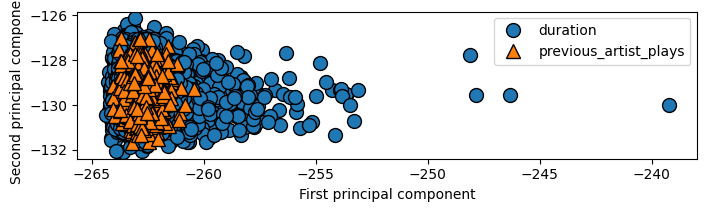

In [39]:
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap, colorConverter, LinearSegmentedColormap

scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

# keep the first two principal components of the data
pca = PCA(n_components=2,random_state=0)
# fit PCA model to breast cancer data
pca.fit(X)

# transform data onto the first two principal components
X_pca = pca.transform(X_scaled)
print("Original shape: {}".format(str(X_scaled.shape)))
print("Reduced shape: {}".format(str(X_pca.shape)))

# plot first vs. second principal component, colored by class
plt.figure(figsize=(8, 8))
discrete_scatter(X_pca[:, 0], X_pca[:, 1], y)
plt.legend(features_to_use, loc="best")
plt.gca().set_aspect("equal")
plt.xlabel("First principal component")
plt.ylabel("Second principal component")


In [ ]:
from imblearn.under_sampling import EditedNearestNeighbours,CondensedNearestNeighbour,NeighbourhoodCleaningRule

print(pd.DataFrame(y).value_counts())
enn = NeighbourhoodCleaningRule(kind_sel="mode",n_neighbors=50)
X_pca_enn,y_enn = enn.fit_resample(X_pca,y)
print(pd.DataFrame(y_enn).value_counts())

In [ ]:

# plot first vs. second principal component, colored by class
plt.figure(figsize=(8, 8))
discrete_scatter(X_pca_enn[:, 0], X_pca_enn[:, 1], y_enn)
plt.legend(features_to_use, loc="best")
plt.gca().set_aspect("equal")
plt.xlabel("First principal component")
plt.ylabel("Second principal component")

In [ ]:
from sklearn.cluster import KMeans

# build the clustering model
kmeans = KMeans(n_clusters=2)
kmeans.fit(X_pca)

discrete_scatter(X_pca[:, 0], X_pca[:, 1], kmeans.labels_, markers='o')
discrete_scatter(
    kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], [0, 1],
    markers='^', markeredgewidth=2)


In [ ]:
from sklearn.cluster import AgglomerativeClustering

agg = AgglomerativeClustering(n_clusters=2)
assignment = agg.fit_predict(X)

discrete_scatter(X_pca[:, 0], X_pca[:, 1], assignment)
plt.legend(["Cluster 0", "Cluster 1"], loc="best")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")


In [37]:
param_grid = [
    {
        "classifier": [DecisionTreeClassifier(),RandomForestClassifier()],
        'undersampler': [EditedNearestNeighbours(),NeighbourhoodCleaningRule(kind_sel="mode")],
        "undersampler__n_neighbors": [1,5,50,100,500]

    }
    #{'classifier': [RandomForestClassifier(random_state=0)],
     #'classifier__max_features': [1, int(sqrt(len(features_to_use))), len(features_to_use)],
     #'classifier__n_estimators': [1, 10, 100],
     #'classifier__min_samples_split': [2, 5, 10]
     #'oversampler': [RandomOverSampler(random_state=0),SMOTE()],
     #'oversampler__sampling_strategy': [0.1,0.3,0.5],
     #'undersampler': [RandomUnderSampler(random_state=0)],
     #'undersampler__sampling_strategy': [0.5,0.7,0.9]
    #},
    #{#'classifier': [RandomForestClassifier(random_state=0)],
    # #'classifier__max_features': [1, int(sqrt(len(features_to_use))), len(features_to_use)],
    # #'classifier__n_estimators': [1, 10, 100],
    # #'classifier__min_samples_split': [2, 5, 10],
    # 'oversampler':[RandomOverSampler(random_state=0),SMOTE()],
    # 'oversampler__sampling_strategy': [0.1,0.3,0.5],
    # 'undersampler': [TomekLinks(sampling_strategy="majority")]
    #}
    ]
#pipe = Pipeline([('classifier', RandomForestClassifier(random_state=0,n_estimators=10,max_features=10))], memory="cache_folder")
pipe = Pipeline([("undersampler",RandomUnderSampler()),('classifier', LogisticRegression())], memory="cache_folder")
grid_search = GridSearchCV(pipe,param_grid,cv=5,scoring="f1_macro",verbose=3)

X_train, X_test, y_train, y_test = train_test_split(X_pca,y,stratify=y,test_size=0.25,random_state=0)
grid_search.fit(X_train,y_train)

print("Best params:\n{}\n".format(grid_search.best_params_))
print("Best cross-validation f1_macro score: {:.2f}".format(grid_search.best_score_))

chosen_model = grid_search

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END classifier=DecisionTreeClassifier(), undersampler=EditedNearestNeighbours(), undersampler__n_neighbors=1;, score=0.518 total time=   0.0s
[CV 2/5] END classifier=DecisionTreeClassifier(), undersampler=EditedNearestNeighbours(), undersampler__n_neighbors=1;, score=0.499 total time=   0.0s
[CV 3/5] END classifier=DecisionTreeClassifier(), undersampler=EditedNearestNeighbours(), undersampler__n_neighbors=1;, score=0.495 total time=   0.0s
[CV 4/5] END classifier=DecisionTreeClassifier(), undersampler=EditedNearestNeighbours(), undersampler__n_neighbors=1;, score=0.525 total time=   0.0s
[CV 5/5] END classifier=DecisionTreeClassifier(), undersampler=EditedNearestNeighbours(), undersampler__n_neighbors=1;, score=0.506 total time=   0.0s
[CV 1/5] END classifier=DecisionTreeClassifier(), undersampler=EditedNearestNeighbours(), undersampler__n_neighbors=5;, score=0.514 total time=   0.0s
[CV 2/5] END classifier=Decision

In [ ]:
y_true = y_test
y_pred = chosen_model.predict(X_test)
print(classification_report(y_true,y_pred))

In [ ]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='example estimator')
display.plot()
plt.show()

In [ ]:
def plot_feature_importances(data,model):
    n_features = data.shape[1]
    plt.barh(np.arange(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), features_to_use)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

plot_feature_importances(X,chosen_model.best_estimator_["classifier"])

In [36]:
review_tracks = pd.read_csv("review_tracks.csv").dropna()
played_tracks = pd.read_csv("played_tracks.csv")
%sql review_tracks2 << select *,(select count(*) from played_tracks pt where pt.artist_id=rt.artist_id) as previous_artist_plays from review_tracks rt
X_pred = review_tracks2[features_to_use]


scaler = StandardScaler()
scaler.fit(X)
X_pred_scaled = scaler.transform(X_pred)

# keep the first two principal components of the data
pca = PCA(n_components=2,random_state=0)
# fit PCA model to breast cancer data
pca.fit(X_pred_scaled)
# transform data onto the first two principal components
X_pred_scaled_pca = pca.transform(X_pred_scaled)


y_predict_proba = pd.DataFrame(chosen_model.predict_proba(X_pred_scaled_pca),columns=["0_probability","1_probability"])
review_tracks2["probability"] = y_predict_proba["1_probability"]
res = review_tracks2.sort_values("probability",ascending=False)
res["uri"].to_csv("review_ranked_output.csv",index=False)
res

Returning data to local variable review_tracks2


,id,track_name,artist_id,artist_name,album_id,album_name,release_date,duration,uri,playlist_offset,...,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,previous_artist_plays,probability
0,10VKxzvtP2nnpDNlt9VzmF,Beast Vision,14TybdraZ1mixyPmP4gjj8,Steel Project,4cp18yhtTJp4hi6DvFFwQI,Beast Vision,2023-01-06,256.883,spotify:track:10VKxzvtP2nnpDNlt9VzmF,0,...,0.505,0.902,0.001480,0.1130,-5.779,0.0690,107.514,0.3280,0,0.0
305,07woAAEKD3og1HdgQzxZNr,Stop The World,1V5yIxSCCn4uYM15q4giYd,NOT,3WetntF3p0n5ZNCR9v0Da7,Stop The World,2022-12-09,151.483,spotify:track:07woAAEKD3og1HdgQzxZNr,305,...,0.395,0.992,0.000000,0.4060,-4.445,0.1990,102.857,0.3420,0,0.0
317,3BDHV8Em5Ynjht9MmoILRW,Kyykkyviini,3iqfiMKG1Qp35bRjj03sb1,Nyrkkitappelu,5MQxgEWlP21yXsbZpW1ljH,Kyykkyviini,2023-01-06,138.520,spotify:track:3BDHV8Em5Ynjht9MmoILRW,317,...,0.587,0.860,0.000000,0.0789,-6.258,0.0471,103.987,0.8550,0,0.0
316,4pR3sJpBVwJrUY76Tf7KSs,Dyeus,6u8nvPk05GEiFOxJX9J2Mb,Nygotha,2fnSVc3ruUucpnCRxvSrGC,Dyeus,2022-12-23,211.631,spotify:track:4pR3sJpBVwJrUY76Tf7KSs,316,...,0.431,0.954,0.766000,0.1760,-4.940,0.1110,95.025,0.3180,0,0.0
315,4KhCx6cW2UPlaL97ShCHnj,Leviathan,68L540i5tc7wLsj4cz2NrI,Nothing Sacred,1H9pCJ8a3URvqgODV21qF6,Leviathan,2022-12-08,208.086,spotify:track:4KhCx6cW2UPlaL97ShCHnj,315,...,0.482,0.963,0.474000,0.2390,-6.077,0.0860,100.641,0.4350,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,3TURLagXZVafDFhYPCyxUg,The Attuning,7bkqNlCj8EPtEkknkEsNs6,Cavern Deep,2L7Bnb3BryZHdNjNSxPVhe,The Attuning,2022-12-16,712.572,spotify:track:3TURLagXZVafDFhYPCyxUg,150,...,0.114,0.581,0.482000,0.0798,-8.991,0.0403,86.223,0.0605,0,0.0
149,4k83APIfSXcm0YxxcnNZC9,This Time Tomorrow 14,3R6c2tWDBeYB1GncjLMn9n,Candlebox,1Iq0NR0ZX2unG1FO1TtXR1,This Time Tomorrow 14,2022-12-09,277.267,spotify:track:4k83APIfSXcm0YxxcnNZC9,149,...,0.483,0.803,0.000004,0.0820,-4.103,0.0481,137.145,0.3580,0,0.0
148,2KLdrBr5SkyuGRWNMOQbhu,Swarming Vulgar Christmas,5M2me1WMtdBlMy8NhFaOsI,Cadaveric Incubator,6AlDdiOibGVvXXmCGgXkag,Split,2022-12-09,335.573,spotify:track:2KLdrBr5SkyuGRWNMOQbhu,148,...,0.264,0.781,0.826000,0.1040,-13.065,0.0418,127.284,0.2490,0,0.0
147,6GoO1nHu5C0jhk2rnDbmq7,Only Life I Know,45a6gCQWq61lIUDmr1tKuO,Bun B,0x06iiRmDrPpU1Wlo5MHoz,Trillstatik 2,2022-12-08,189.274,spotify:track:6GoO1nHu5C0jhk2rnDbmq7,147,...,0.438,0.819,0.000000,0.5060,-6.854,0.2930,79.110,0.5350,0,0.0


In [ ]:
res["probability"].value_counts()

0
1


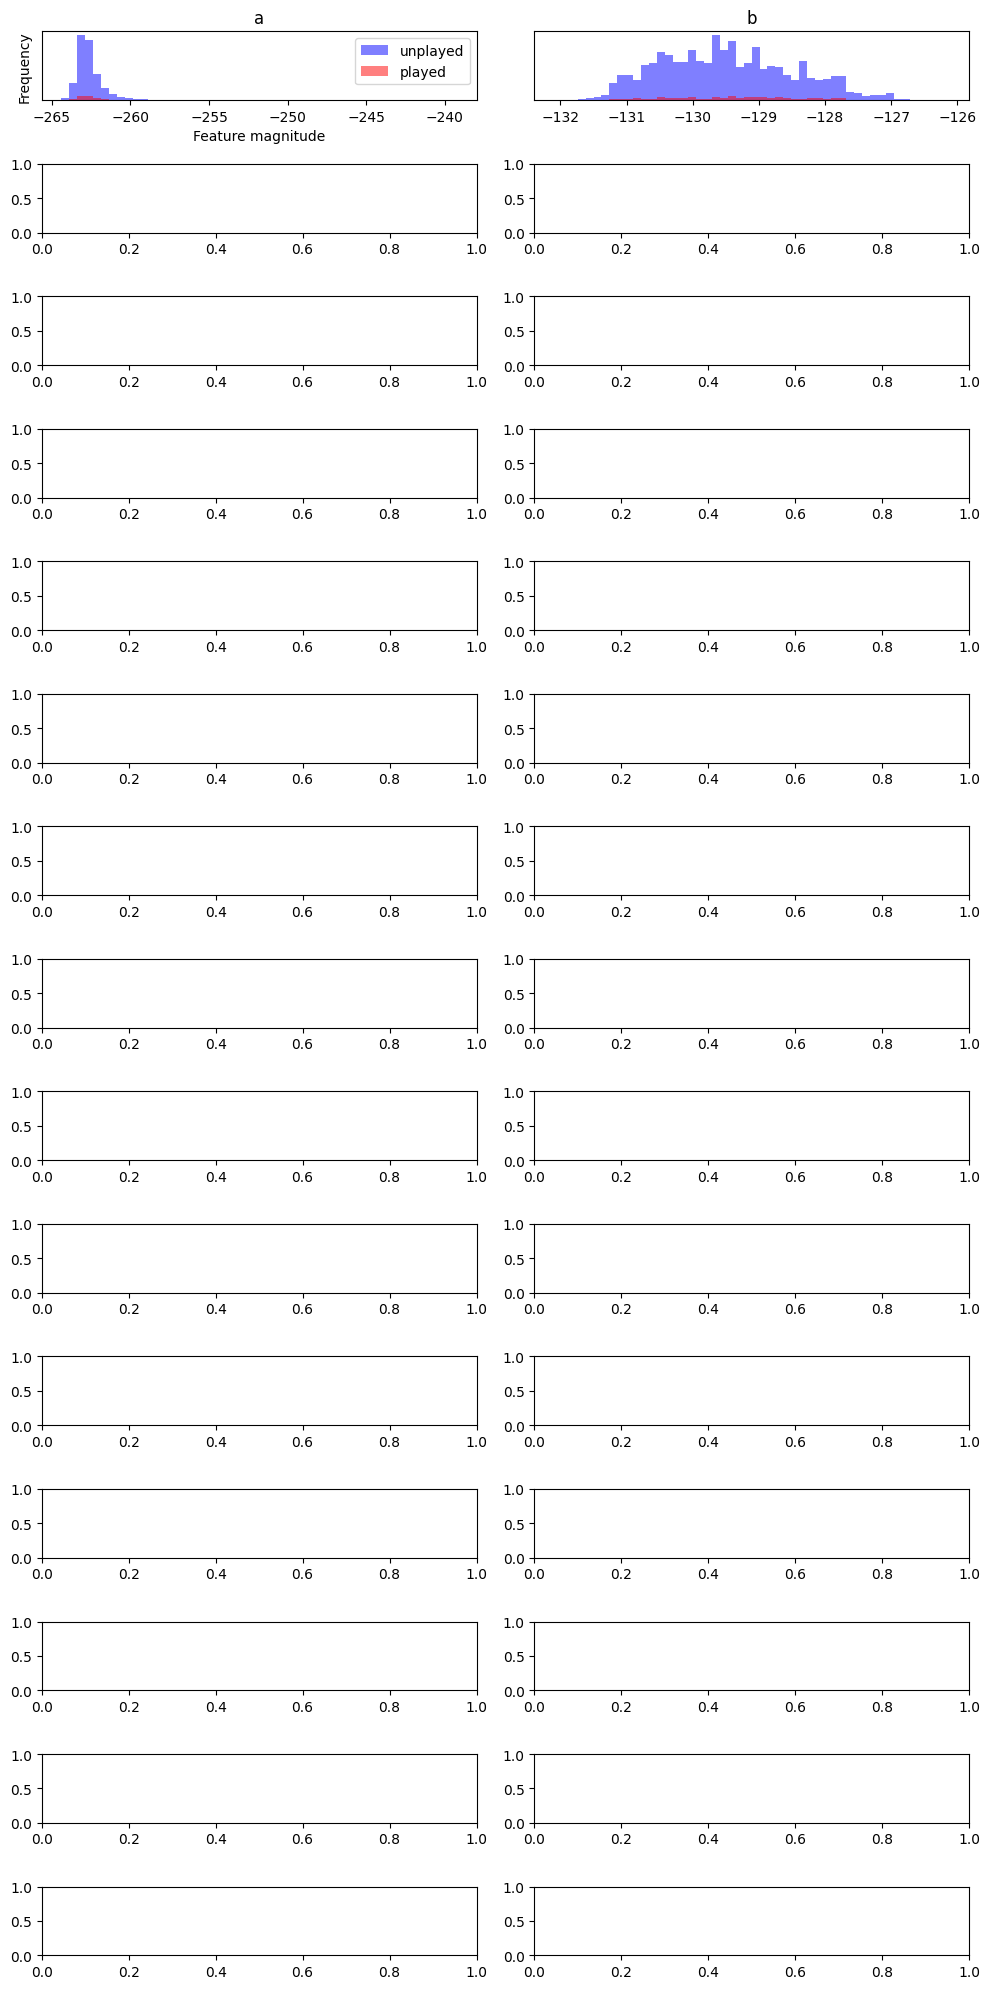

In [41]:
data = pd.DataFrame(X_pca,columns=["a","b"])
data["played"] = y

features_to_use_hist = ["a","b"]

fig, axes = plt.subplots(15, 2, figsize=(10, 20))
unplayed = data[data.played == 0][features_to_use_hist]
played = data[data.played == 1][features_to_use_hist]

ax = axes.ravel()

for i in range(len(features_to_use_hist)):
    print(str(i))
    _, bins = np.histogram(data[features_to_use_hist].iloc[:, i], bins=50)
    ax[i].hist(unplayed.iloc[:, i], bins=bins, color="blue", alpha=.5)
    ax[i].hist(played.iloc[:, i], bins=bins, color="red", alpha=.5)
    ax[i].set_title(features_to_use_hist[i])
    ax[i].set_yticks(())
ax[0].set_xlabel("Feature magnitude")
ax[0].set_ylabel("Frequency")
ax[0].legend(["unplayed", "played"], loc="best")
fig.tight_layout()